In [1]:
import numpy as np
import os
import os
import tarfile
from six.moves import urllib
np.random.seed(42)

In [2]:
#Scrape Data
ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
PATH = "datasets/housing"
URL = ROOT+PATH+"/housing.tgz"

def fetch_housing_data(housing_url=URL, housing_path=PATH):
    '''
    creates datasets/housing directory
    downloads and extracts file
    '''
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
import pandas as pd
def load_data(housing_path=PATH):
    '''
    returns the dataset from above
    '''
    fetch_housing_data()
    housing_csv = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(housing_csv)

In [4]:
housing_data = load_data()
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


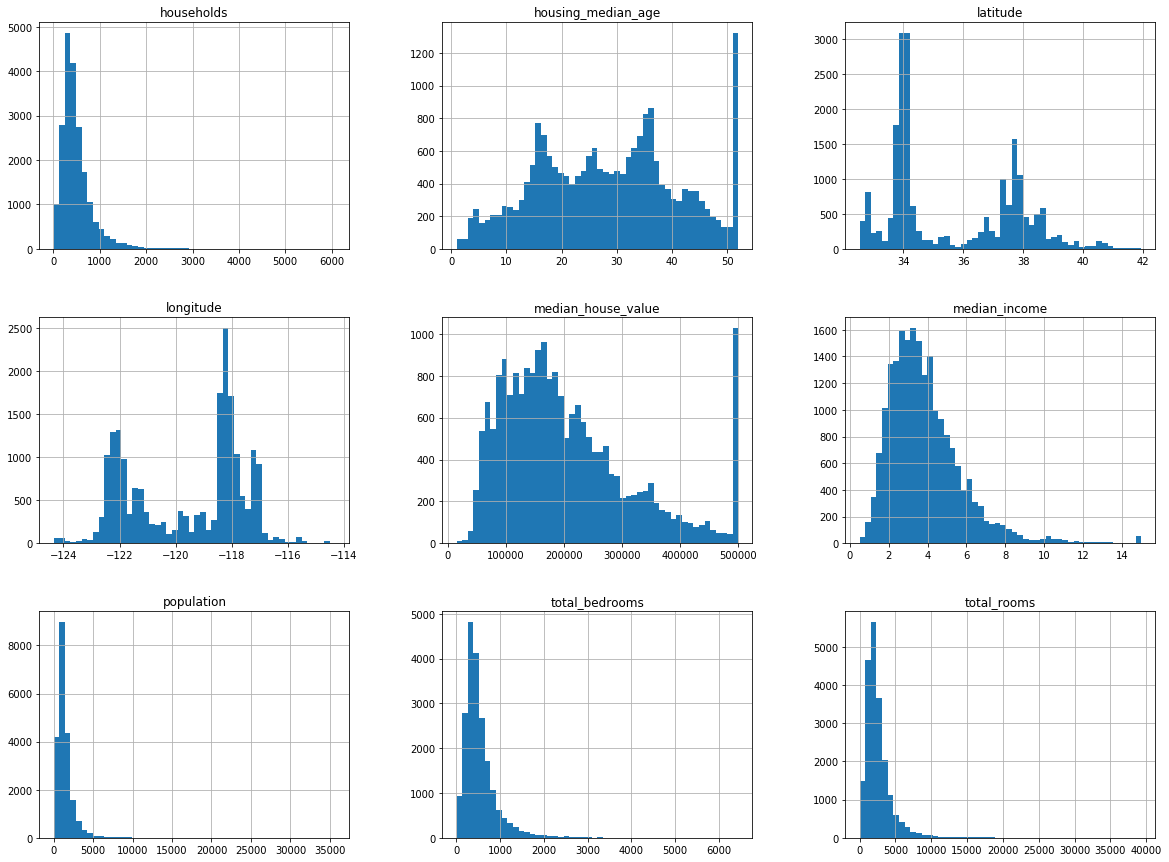

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
housing_data.hist(bins =50,figsize=(20,15))
plt.show()

In [6]:
def split_set(data, test_ratio):
    '''
    splits data set randomly with a given ratio in the test set and the rest in the training set
    returns the two sets
    '''
    shuffled_data = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_set = shuffled_data[:test_set_size]
    train_set = shuffled_data[test_set_size:]
    return (data.iloc[train_set], data.iloc[test_set])

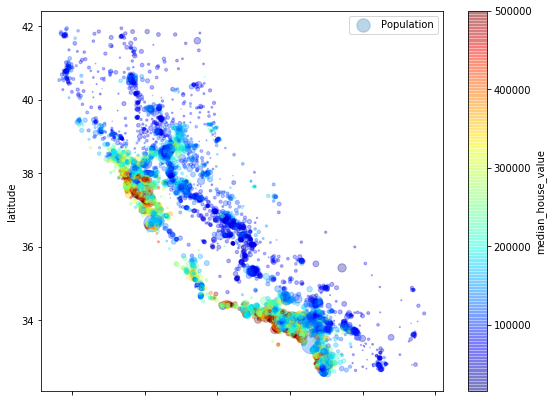

In [7]:
train_set, test_set = split_set(housing_data, .2)

#gaining data insights

housing = train_set.copy()
housing.plot(kind="scatter",
             figsize=(9,7),
             x="longitude",
             y="latitude",
             alpha=0.3,
            c="median_house_value",
            s=housing["population"]/100,
            label="Population",
            cmap=plt.get_cmap("jet"),
            colorbar=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ae0dda0>,
      dtype=object)

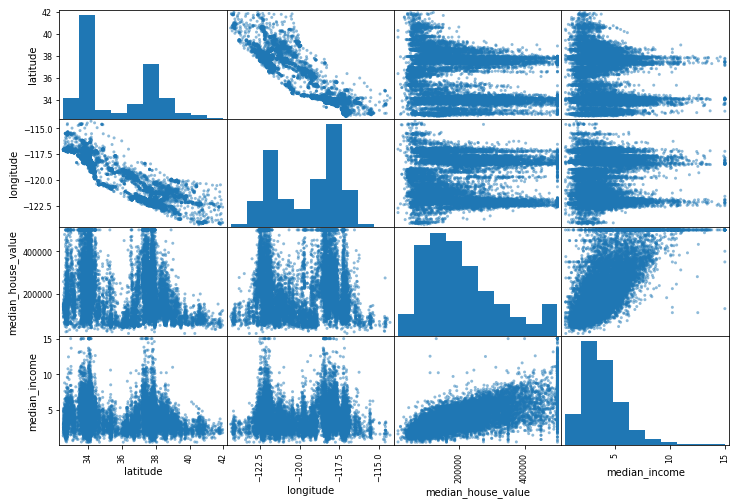

In [8]:
###
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values()
from pandas.plotting import scatter_matrix
attributes = ["latitude", "longitude", "median_house_value", "median_income"]
scatter_matrix(housing[attributes], figsize=(12,8))

In [9]:
housing["percent_bedrooms"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values()

percent_bedrooms           -0.257419
latitude                   -0.142983
longitude                  -0.046349
population                 -0.026032
population_per_household   -0.022030
total_bedrooms              0.047980
households                  0.063714
housing_median_age          0.103706
total_rooms                 0.133989
median_income               0.690647
median_house_value          1.000000
Name: median_house_value, dtype: float64

In [13]:
#preparing the data

from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder

housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()
housing_nums = housing.drop("ocean_proximity", axis=1)

imputer = Imputer(strategy="median")
#find median values
imputer.fit(housing_nums)
#replace Nan values with said median values
x = imputer.transform(housing_nums)
housing_nums_full = pd.DataFrame(x, columns=housing_nums.columns)

#encoding labels
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_num = encoder.fit_transform(housing_cat)
#translating to 1-hot encoding (all values 0 except the one that it is which is 1, gets aroung issue of 1 being closer to 2)
encoder = OneHotEncoder()
#reshape(-1,1) means 1 element per row for x columns (the -1 means numpy figures out the columns to make this work)
housing_cat_1hot = encoder.fit_transform(housing_cat_num.reshape(-1,1))
housing_cat_1hot


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

#building custom transformer

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_percent_bedrooms = True):
        self.add_percent_bedrooms = add_percent_bedrooms
    def fix(self, X, y=None):
        return self
    def transform(self, X, y=None):
        

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,INLAND
17848,-121.86,37.42,20.0,5032.0,808.0,2695.0,801.0,6.6227,<1H OCEAN
6252,-117.97,34.04,28.0,1686.0,417.0,1355.0,388.0,2.5192,<1H OCEAN
9389,-122.53,37.91,37.0,2524.0,398.0,999.0,417.0,7.9892,NEAR BAY
6113,-117.90,34.13,5.0,1126.0,316.0,819.0,311.0,1.5000,<1H OCEAN
6061,-117.79,34.02,5.0,18690.0,2862.0,9427.0,2777.0,6.4266,<1H OCEAN
